In [1]:
import pandas as pd
import numpy as np

In [35]:
def read_file(path):
#     df = pd.read_csv(path,delimiter = '\t',skiprows = [0,1,2,3])
    df = pd.read_csv(path,delimiter = '\t')
    return df

In [36]:
raw_data = read_file("../data_expression_median.txt")
# raw_data

In [37]:
raw_data.shape

(24368, 1906)

In [38]:
# raw_data = raw_data.iloc[:,:100]

In [39]:
def preprocessing(df):
    # reset column name and drop all row Nan value
    df = df.T
    df = df.drop(['Entrez_Gene_Id'], axis = 0)
    df = df.dropna()
#     df.iloc[:,0:24368] = df.iloc[:,0:24368].astype('float64')
    return df

In [40]:
df = preprocessing(raw_data)
# df

In [42]:
Hugo_Symbol = df.iloc[0,:]

In [43]:
df = df.drop(['Hugo_Symbol'], axis = 0)

In [10]:
def preprocessing_clinical(df):
    # reset column name and drop all row Nan value
    df.columns = df.iloc[3]
    df = df.iloc[4:]
    df = df.dropna()
    # reset data type of each column
    df["LYMPH_NODES_EXAMINED_POSITIVE"] = df["LYMPH_NODES_EXAMINED_POSITIVE"].astype('int64')
    df["NPI"] = df["NPI"].astype('float64')
    df["CELLULARITY"] = df["CELLULARITY"].astype('category')
    df["CHEMOTHERAPY"] = df["CHEMOTHERAPY"].astype('category')
    df["COHORT"] = df["COHORT"].astype('int64')
    df["ER_IHC"] = df["ER_IHC"].astype('category')
    df["HER2_SNP6"] = df["HER2_SNP6"].astype('category')
    df["HORMONE_THERAPY"] = df["HORMONE_THERAPY"].astype('category')
    df["INFERRED_MENOPAUSAL_STATE"] = df["INFERRED_MENOPAUSAL_STATE"].astype('category')
    df["INTCLUST"] = df["INTCLUST"].astype('category')
    df["AGE_AT_DIAGNOSIS"] = df["AGE_AT_DIAGNOSIS"].astype('float64')
    df["OS_MONTHS"] = df["OS_MONTHS"].astype('float64')
    df["OS_STATUS"] = df["OS_STATUS"].astype('category')
    df["CLAUDIN_SUBTYPE"] = df["CLAUDIN_SUBTYPE"].astype('category')
    df["THREEGENE"] = df["THREEGENE"].astype('category')
    df["VITAL_STATUS"] = df["VITAL_STATUS"].astype('category')
    df["LATERALITY"] = df["LATERALITY"].astype('category')
    df["RADIO_THERAPY"] = df["RADIO_THERAPY"].astype('category')
    df["HISTOLOGICAL_SUBTYPE"] = df["HISTOLOGICAL_SUBTYPE"].astype('category')
    df["BREAST_SURGERY"] = df["BREAST_SURGERY"].astype('category')
    
    return df

def category_encoding(df):
    char_cols = df.dtypes.pipe(lambda x: x[x == 'category']).index
    label_mapping = {}

    for c in char_cols:
        df[c], label_mapping[c] = pd.factorize(df[c])
    return (df,label_mapping)

In [11]:
def data_create(data):
    less_10_year = data.OS_MONTHS <= 120
    dead_other_or_living = data.VITAL_STATUS.isin([0, 2])
    bad_cases = less_10_year & dead_other_or_living
    data_cli_final = data.drop(data[bad_cases].index)
    data_cli_final['Y'] = (data_cli_final['OS_MONTHS'] <= 120)
    y_data = data_cli_final['Y']
    y_data = y_data * 1
#     x_data = data_cli_final.iloc[:, 1:].drop(columns=['OS_STATUS', 'OS_MONTHS', 'VITAL_STATUS', 'Y'])
    x_data = data_cli_final.drop(columns=['OS_STATUS', 'OS_MONTHS', 'VITAL_STATUS', 'Y'])
    return (x_data, y_data)

In [12]:
clinical_data = read_file("../data_clinical_patient.txt")

In [14]:
# clinical_data.columns = clinical_data.iloc[3]
# clinical_data = clinical_data.iloc[4:]
# clinical_data = clinical_data.dropna()

In [15]:
data = preprocessing_clinical(clinical_data)

In [16]:
data, mapping = category_encoding(data)

In [17]:
(x_data, y_data) = data_create(data)

In [18]:
patient_df = pd.DataFrame(data = {'PATIENT_ID': x_data['PATIENT_ID'], 'Y_label': y_data})

In [20]:
# len(y_data)

1125

In [21]:
# less_10_year = data.OS_MONTHS <= 120

In [22]:
# dead_other_or_living = data.VITAL_STATUS.isin([0, 2])

In [44]:
merged = pd.merge(left=df,right=patient_df, left_on=df.index, right_on='PATIENT_ID')

In [45]:
merged.shape

(1119, 24370)

In [46]:
# patient_df

In [47]:
Hugo_names = list(Hugo_Symbol)

In [48]:
Hugo_names.append('OS_STATUS')

In [49]:
merged = merged.drop(['PATIENT_ID'], axis = 1)

In [50]:
merged.columns = Hugo_names

In [51]:
merged.to_csv('test_expression.csv', index = False, header = True)

In [63]:
df['Hugo_Symbol'] = Hugo_Symbol

In [65]:
Hugo_Symbol

In [56]:
Hugo_Symbol

0               RERE
1             RNF165
2           CD049690
3           BC033982
4               PHF7
5              CIDEA
6              PAPD4
7           AI082173
8            SLC17A3
9                SDS
10          ATP6V1C2
11                F3
12            FAM71C
13          AK055082
14          BU687559
15             LIN52
16             PCOTH
17              GRM1
18               FXN
19            SLC9A1
20               PML
21          CR749394
22             CD164
23          DB337918
24           MOBKL2A
25          HGC6.1.1
26             OR1J2
27              GNG5
28             TAF15
29             EXTL3
            ...     
24338          ELANE
24339         SHISA2
24340          BCAT1
24341       BU738502
24342        NCKAP1L
24343        TMEM146
24344       AK098705
24345        PSMC3IP
24346          TEAD1
24347      LOC253724
24348       BM725158
24349          GRHPR
24350    RAB4B-EGLN2
24351         TBC1D4
24352        ANGPTL2
24353       AF086457
24354       A

In [107]:
X = merged.iloc[:,0:24368].values
y = merged[['OS_STATUS']].values

In [108]:
#Test train split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [109]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [110]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)


In [115]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc 
from sklearn import preprocessing

Best parameters set found on development set:

{'C': 10, 'kernel': 'linear'}


<Figure size 432x288 with 0 Axes>

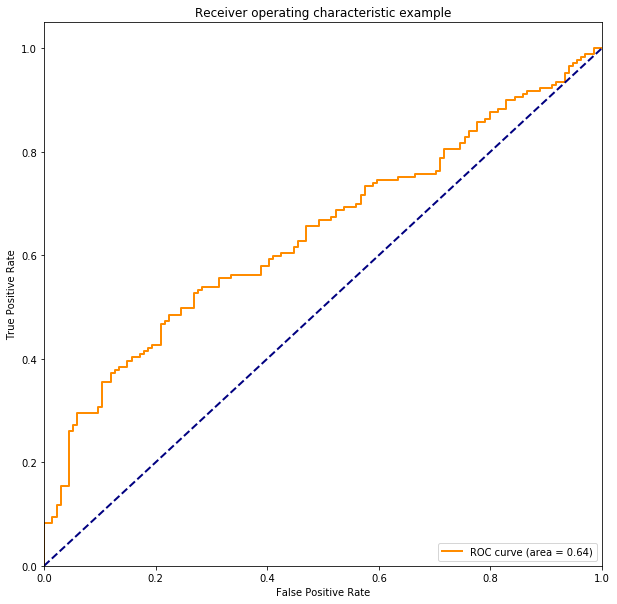

In [126]:
tuned_parameters = [{'kernel': ['linear'], 'C': [1, 10]}]

# Grid Search
clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                   scoring='f1')
clf.fit(X_train, np.ravel(y_train))

print("Best parameters set found on development set:")
print()
print(clf.best_params_)

y_score = clf.decision_function(X_test)

# Plot ROC AUC Curve
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_score) 
roc_auc = auc(fpr,tpr) 

plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [123]:
#Create classifier object
from sklearn.svm import SVC
classifier_svm_kernel = SVC(C=5.0,kernel='rbf', gamma=0.12,tol=0.00001)
classifier_svm_kernel.fit(X_train,np.ravel(y_train))

#Predict the result for test values
y_pred = classifier_svm_kernel.predict(X_test)


In [124]:
#Comparing the predictions with the actual results
comparison = pd.DataFrame(y_test,columns=['y_test'])
comparison['y_predicted'] = y_pred
#comparison

In [ ]:
#principalDf = pd.DataFrame(data = principalComponents)
#finalDf = pd.concat([principalDf, y], axis = 1)
